In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

import gym
from gym.wrappers import Monitor
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob


%matplotlib inline



In [ ]:
class DeepNetwork(nn.Module):
    # TODO: Define the Deep Q Network class here.
    # This class should estimate Q(s, a).
    #
    # Hints: 1- Define the architecture of the class in the init method.
    #        2- Define a method that takes a state as input
    #           an outputs action-values of the state.
    #        3- You may also define methods for saving and loading
    #           network weights.
    def __init__(self, state_size, action_size, seed):

        super(DeepNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64) 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state) 
        x = F.relu(x) 
        x = self.fc2(x) 
        x = F.relu(x)
        return self.fc3(x) 

In [ ]:
class Agent():
    # TODO: Define the DQN Agent here.
    #
    # Hints: 1- Initialize a Neural Network (using DeepNetwork class),
    #           and other essential parameters in the init method.
    #        2- Define a method for taking action using 
    #           epsilon-greedy policy based on the DQN outputs.
    #        3- Define a learning method for updating DQN weights.
    #        4- You may also need to define some extra methods
    #           for decrementing epsilon, saving, and loading a trained network.

    def __init__(self, environment, learning_rate = 1e-5 , seed=0):

        self.env = environment
        self.state_size = environment.observation_space.shape[0]
        self.N_A = environment.action_space.n # number of actions in action space
        self.seed = random.seed(seed)    
        self.local_model = DeepNetwork(self.state_size, self.N_A, seed).to(device) # Local Q Network
        self.target_model = DeepNetwork(self.state_size, self.N_A, seed).to(device) # Target Q network
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=learning_rate)
        self.epsilon = 1
        self.discount = 0.99


    def action_selection(self , state ): 
        actions = list(range(self.N_A))
        self.local_model.eval() # put the network in evaluation mode
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # Convert state from array type to tensor type
        with torch.no_grad():
            action_values = self.local_model(state)
            
        self.local_model.train() #put the network in training mode

        action_values = list(action_values.cpu().data.numpy())
        action_values = action_values[0].tolist()
        A_star = action_values.index(max(action_values)) # A = argmax Q(S,A,theta)
        policy = ['greedy' , 'random'] 
        policy = random.choices(policy, weights=[1-self.epsilon , self.epsilon] )[0]
        if policy == 'greedy':
           Q_value = action_values[A_star] # Q(S , A , theta)
           return A_star , Q_value
        else:
           A_t = random.choice(actions)
           Q_value = action_values[A_t] # Q(S , A , theta)
           return A_t , Q_value 


    def update_weight(self, batch): # Learn new weights for Local Q network

        states, actions, rewards, next_states, dones = batch  # extract the required data from the batch of samples

        max_Q_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1) # max Q(S',A',theta)
        target_Q_value = rewards + self.discount * max_Q_next * (1 - dones)  # TD_target for Q learning: R + gamma * max Q(S',A',theta)
        predicted_Q_value = self.local_model(states).gather(1, actions)  # Filter a vecor of Q(S,A,theta) for each chosen action in S.
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(predicted_Q_value, target_Q_value)  # MSE loss function. 
        self.optimizer.zero_grad()  # Sets all gradients to zero before calculating new gradients
        loss.backward() # Compute the gradients of MSE loss w.r.t weights
        self.optimizer.step() # Backpropagate the the gradients to weights and update them

    def update_target(self, local_model, target_model): 

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)  # copy local network weights to target network

    def decrement_epsilon(self):
        self.epsilon *= 0.995

    def save_model(self):
        torch.save(agent.local_model.state_dict(), 'DQN Model.pth')


In [ ]:
class ReplayBuffer():
    # TODO: Define a class for storing states, actions, and rewards.
    # It is suggested to label terminal states.
    #
    # Hints: 1- This class should contain 2 methods. One for storing
    #           transtions, and the other for sampling a batch of 
    #           experiences.

    def __init__(self, replay_buffer_size, batch_size, seed=0):

        self.buffer = deque(maxlen=replay_buffer_size)
        self.buffer_lenght = 0
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["current_state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def store_transitions(self, current_state, action, reward, next_state, done):
        e = self.experience(current_state, action, reward, next_state, done)
        self.buffer.append(e)
        self.buffer_lenght += 1
    
    def take_sample(self , batch_size): # Takes random sample of size batch_size randomly from buffer
        selected_batch = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.current_state for e in selected_batch if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in selected_batch if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in selected_batch if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in selected_batch if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in selected_batch if e is not None]).astype(np.uint8)).float()

        # Add the constructed Tensors to GPU to work with deep Q network model
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)

        return (states, actions, rewards, next_states, dones)

In [ ]:
!pip3 install box2d-py==2.3.8

     |████████████████████████████████| 448 kB 4.3 MB/s 


In [ ]:
def start_learning(agent , replay_buffer , stoping_criteria = 'average_reward' , t_steps = 4 , episodes = 1000 , max_iteration = 1000):
    i_step = 0
    scores = []                       
    for e in range(1, episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_iteration):
            action , _ = agent.action_selection(state)
            next_state, reward, done, _ = agent.env.step(action)
            replay_buffer.store_transitions(state, action ,reward, next_state, done)

            i_step +=1 
            if replay_buffer.buffer_lenght > batch_size:
                selected_batch = replay_buffer.take_sample(batch_size)
                agent.update_weight(selected_batch)

                if (i_step) % t_steps == 0:
                    agent.update_target(agent.local_model, agent.target_model)

            state = next_state
            score += reward
            if done:
                break 
                
        scores.append(score)             
        agent.decrement_epsilon()
        average_recent_reward = []

        if len(scores) < 100:
           average_recent_reward = np.mean(scores)
        else:
           average_recent_reward = np.mean(scores[-100 :])
        print('\rEpisode {}\tAverage Reward: {:.2f}'.format(e, np.mean(average_recent_reward)), end="")
        if e % 100 == 0:
            print('\rEpisode {}\tAverage Reward: {:.2f}'.format(e, np.mean(average_recent_reward)))

        if stoping_criteria == 'average_reward': # early stopping criteria
            if np.mean(average_recent_reward)>=220.0: 
                print('\nAgent converged in {:d} episodes!\tAverage Reward: {:.2f}'.format(e-100, np.mean(average_recent_reward)))
                agent.save_model()  # save the model
                return scores

    agent.save_model()  # save the model
    print('\nReached max episodes. \tAverage Reward : {:.2f}'.format( np.mean(average_recent_reward)))
    return scores

In [ ]:
EPISODES=1000  
max_iteration=1000  # maximum iteration (steps) in the environment
replay_buffer_size = int(1e5)  # Size of experience replay buffer
batch_size = 64       
learning_rate = 5e-4   
update_target_steps = 4    # update target network after certain steps    
env = gym.make('LunarLander-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = Agent(env , learning_rate)
replay_buffer = ReplayBuffer(replay_buffer_size , batch_size)

Rewards = start_learning(agent , replay_buffer , stoping_criteria = 'average_reward' , t_steps = update_target_steps ,episodes = EPISODES , max_iteration = max_iteration)

Episode 100	Average Reward: -116.23
Episode 200	Average Reward: -64.91
Episode 300	Average Reward: 4.49
Episode 400	Average Reward: 118.58
Episode 500	Average Reward: 215.43
Episode 505	Average Reward: 220.08
Agent converged in 405 episodes!	Average Reward: 220.08


<Figure size 432x288 with 0 Axes>

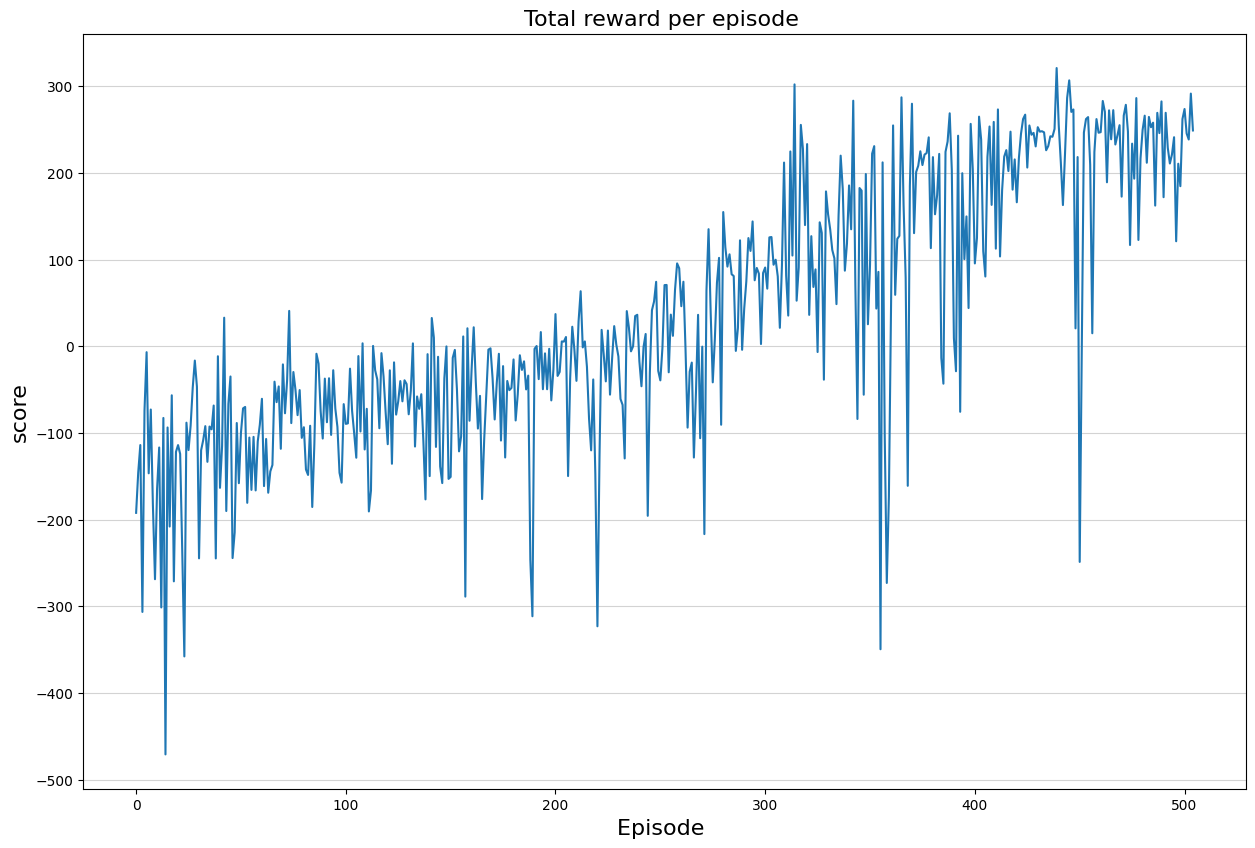

In [ ]:
fig = plt.figure()
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)
plt.grid(axis='y' , color='lightgrey')
plt.title("Total reward per episode ", fontsize=16)
plt.plot(np.arange(len(Rewards)), Rewards)
plt.ylabel('score' , fontsize=16)
plt.xlabel('Episode ', fontsize=16)
plt.show()

In [ ]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
from gym import wrappers
import io
import base64
from IPython.display import HTML

In [ ]:
import cv2

cap= cv2.VideoCapture(0)

width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer= cv2.VideoWriter('LunarLander.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (600,400))

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    #vid = video_recorder.VideoRecorder(env, path="/content/{}.mp4".format(env_name))
    agent.local_model.load_state_dict(torch.load('DQN Model.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        writer.write(frame)
        action = agent.action_selection(state)

        state, reward, done, _ = env.step(action[0])
        
    env.close()
    writer.release()
    cv2.destroyAllWindows()


In [ ]:
show_video_of_model(agent, 'LunarLander-v2')